In [225]:
import import_ipynb
from Functions import *
import torch.nn.functional as Fun
import torch
from torch import optim
import matplotlib.pyplot as plt
import time

In [226]:
def Extract(Params):
    C = Params['C']
    P = Params['P']
    F = Params['F']
    B = Params['B']
    WPP = Params['WPP']
    WPF = Params['WPF']
    K = Params['K']
    KP = Params['KP']
    KPast = Params['KPast']
    KFuture = Params['KFuture']
    return C,P,F,B,K,KP,KPast,KFuture,WPP,WPF

## Generate Random Values for Parameters

In [227]:
def Gen_Params(Size,N):
    C = torch.rand((1,3,Size[0],Size[1]),requires_grad=True)
    P = [torch.rand((1,3,Size[0],Size[1]),requires_grad=True) for _ in range(N)]
    F = [torch.rand((1,3,Size[0],Size[1]),requires_grad=True) for _ in range(N)]
    B = torch.rand((1,3,Size[0],Size[1]),requires_grad=True)
    K = torch.rand((3,3,3,3),requires_grad=True)
    KP = torch.rand((3,3,3,3),requires_grad=True)
    KPast = [torch.rand((3,3,3,3),requires_grad=True) for _ in range(N)]
    KFuture = [torch.rand((3,3,3,3),requires_grad=True) for _ in range(N)]
    WPP = [torch.rand((1,3,Size[0],Size[1]),requires_grad=True) for _ in range(N)]
    WPF = [torch.rand((1,3,Size[0],Size[1]),requires_grad=True) for _ in range(N)]
    return C,P,F,B,K,KP,KPast,KFuture,WPP,WPF

## Objective Function

$$F(I,P,F,M_{Current},M_{PastFreq},M_{FutureFreq},M_{Bias}) = \sqrt{IFT\left(M_{Current}*FT(I)+M_{Bias}+\sum^N_{i=0} M_{PastFreq}[i]*FT(P[i])+M_{FutureFreq}[i]*FT(F[i])\right)^2}$$<br>
Where $F$ is the function that generates the new frame, $I$ is the current frame in the video, $P$ and $F$ are lists of past and future frames respectively of size $N$, $M_{Current}$ is a mask of weights for the pixel frequencies in $I$, $M_{PastFreq}$ and $M_{FutureFreq}$ are lists of weight masks for the pixel frequencies in for each frame of $P$ and $F$ respectively, and $M_{Bias}$ is a mask of the bias for the frequencies.<br>
$FT()$ is the Fourier Transform and $IFT()$ is the Inverse Fourier Transform. 

In [228]:
def ObjFun(Current,Past,Future,C,P,F,B,K,KP,KPast,KFuture,WPP,WPF):
    currentF = torch.fft.fft2(Current)
    pastF = [torch.fft.fft2(p) for p in Past]
    futureF = [torch.fft.fft2(f) for f in Future]
    
    sumF = C*currentF
    
    for pf,p in zip(pastF,P):
        sumF = sumF + pf*p
        
    for ff,f in zip(futureF,F):
        sumF = sumF + ff*f
        
    sumF = sumF + B
    
    #for pf,wp in zip(pastF,WPP):
     #   sumF = sumF + pf*currentF*wp
    
    #for ff,wf in zip(futureF,WPF):
     #   sumF = sumF + ff*currentF*wf
    
    SumP = torch.fft.ifft2(sumF)
    Pred = torch.sqrt(SumP**2).real
    #Pred = Fun.relu(Fun.conv2d(SumP,KP,stride=1,padding=1))
    #Pred = Fun.relu(Fun.conv2d(Current,K,stride=1,padding=1)) #+ Pred
    #for kp,p in zip(KPast,Past):
     #   Pred = Pred + Fun.relu(Fun.conv2d(p,kp,stride=1,padding=1))
    #for kf,f in zip(KFuture,Future):
     #   Pred = Pred + Fun.relu(Fun.conv2d(f,kf,stride=1,padding=1))
    
    return Pred

## Draw Inconsistencies and noise to frame

In [229]:
def AddOneInc1(F,Op,x,y,xl,yl):
    if isinstance(F, torch.Tensor):
        # Convert to NumPy Array
        F = F.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255
    # Copy of original array
    I = F.astype(np.uint8).copy()
    # Random location
    #x, y = random.randint(0, 4 * I.shape[0] // 5), random.randint(0, 4 * I.shape[1] // 5)
    # Random size
    #xl,yl = random.randint(x+1,x+int(F.shape[1]*0.2)),random.randint(y+1,y+int(F.shape[0]*0.2))
    # Random option
    #Op = random.randint(0, 8)
    if Op == 0: #Draw square with changes color ranges
        I[x:xl, y:yl] = change_range_colors(I[x:xl,y:yl], (random.randint(30, 140), random.randint(30, 140), random.randint(30, 140)), (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)))
    elif Op == 1: #Draw square with random color
        R, G, B = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        I[x:xl,y:yl] = change_range_colors(I[x:xl,y:yl], (R, G, B), (R, G, B))
    elif Op == 2: #Draw line with random color
        Thick = random.randint(1, 10)
        l2 = random.randint(5, I.shape[1]//10)
        I = cv2.line(I, (x, y), (xl,yl), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), Thick)
    elif Op == 3: #Draw black line
        Thick = random.randint(1, 5)
        l2 = random.randint(5, I.shape[1]//10)
        I = cv2.line(I, (x, y), (xl, yl), (0, 0, 0), Thick)  
    elif Op == 4: #Add a square of noise
        I[x:xl,y:yl] = I[x:xl,y:yl] + np.random.random_integers(-10,10,I[x:xl,y:yl].shape)
    elif Op == 5: #Convolution with a random kernel
        kernel = np.random.rand(3,3)
        I[x:xl,y:yl] = cv2.filter2D(I[x:xl,y:yl],-1,kernel)
    elif Op == 6:
        I[x:xl,y:yl] = img_deformation(I[x:xl,y:yl],random.randint(10,50),random.randint(10,100))
    else:# Op == 7:
        I[x:xl,y:yl] = random_point_warp(I[x:xl,y:yl],random.randint(1,5))
    #else:
         #I[x:xl,y:yl] = random_PRR(I[x:xl,y:yl])
    # Convert back to tensor
    I_tensor = torch.tensor(I,dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)/255.0
    return I_tensor

## Optical Flow Function

In [230]:
def OF(img1: torch.Tensor, img2: torch.Tensor, alpha: float = 1.0, iterations: int = 100, kernel_size: int = 2):
    assert img1.shape == img2.shape, "Images must have the same shape"
    
    # Convert to grayscale to simplify optical flow calculation
    def rgb_to_grayscale(img):
        return 0.2989 * img[0,0, :, :] + 0.5870 * img[0,1, :, :] + 0.1140 * img[0,2, :, :]
    
    I1 = rgb_to_grayscale(img1)
    I2 = rgb_to_grayscale(img2)
    
    # Initialize optical flow vectors (u for x direction, v for y direction)
    u = torch.zeros_like(I1, requires_grad=True)
    v = torch.zeros_like(I1, requires_grad=True)
    
    # Define convolution kernels for gradients
    kernel_x = torch.ones((1, 1, kernel_size, kernel_size), dtype=torch.float32)
    kernel_x[0, 0, :, :kernel_size//2] = -1  # Set left half to -1
    kernel_y = kernel_x.transpose(2, 3)  # Transpose for y-direction

    # Compute gradients with consistent padding
    Ix = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_x, padding=kernel_size//2).squeeze(0).squeeze(0)
    Iy = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_y, padding=kernel_size//2).squeeze(0).squeeze(0)
    It = I2 - I1  # Temporal gradient

    # Ensure all tensors have matching dimensions by cropping to the smallest dimensions
    min_h = min(Ix.shape[-2], Iy.shape[-2], It.shape[-2], I1.shape[-2])
    min_w = min(Ix.shape[-1], Iy.shape[-1], It.shape[-1], I1.shape[-1])
    Ix, Iy, It = Ix[:min_h, :min_w], Iy[:min_h, :min_w], It[:min_h, :min_w]
    u, v = u[:min_h, :min_w], v[:min_h, :min_w]
    
    # Iteratively update the optical flow
    for _ in range(iterations):
        # Average flow in the neighborhood using the specified kernel size
        u_avg = Fun.avg_pool2d(u.unsqueeze(0).unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze(0).squeeze(0)
        v_avg = Fun.avg_pool2d(v.unsqueeze(0).unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze(0).squeeze(0)
        
        # Ensure u_avg and v_avg are also cropped to the smallest dimensions
        u_avg, v_avg = u_avg[:min_h, :min_w], v_avg[:min_h, :min_w]
        
        # Optical flow update step based on Horn-Schunck method
        P = Ix * u_avg + Iy * v_avg + It
        D = alpha ** 2 + Ix ** 2 + Iy ** 2
        
        u = u_avg - (Ix * P) / D
        v = v_avg - (Iy * P) / D

    # Stack u and v to form the flow tensor
    flow = torch.stack((u, v), dim=0)
    return flow


In [231]:
def frequency_loss(image1, image2):
    # Apply 2D Fourier Transform to the images along the height and width dimensions
    freq_image1 = torch.fft.fft2(image1*255, dim=(-2, -1))
    freq_image2 = torch.fft.fft2(image2*255, dim=(-2, -1))
    # Compute the magnitude of the frequencies (ignore the phase for this loss)
    mag_image1 = torch.abs(freq_image1)
    mag_image2 = torch.abs(freq_image2)
    # Compute the loss between the magnitudes of the frequency components
    loss = Fun.mse_loss(mag_image1, mag_image2)
    return loss

In [232]:
def read_random_video(directory, N):
    # Get a random video from the directory
    videos = [f for f in os.listdir(directory) if f.endswith(('.mp4', '.avi', '.mov'))]
    if not videos:
        raise ValueError("No video files found in the directory")
    
    video_path = os.path.join(directory, random.choice(videos))
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file {video_path}")
    
    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Ensure N sequential frames and next N frames can be fetched
    if total_frames < 2 * N + 1:
        raise ValueError(f"Video does not have enough frames for N={N} sequential frames.")
    
    # Randomly select a start frame ensuring there are enough remaining frames
    start_frame = random.randint(0, total_frames - (2 * N + 1))
    
    # Read the first N sequential frames
    sequential_frames = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            raise ValueError("Error reading frame from video")
        sequential_frames.append(frame)

    # Read the next single frame
    ret, next_frame = cap.read()
    if not ret:
        raise ValueError("Error reading next frame from video")
    
    # Read the next N sequential frames after the next frame
    next_sequential_frames = []
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            raise ValueError("Error reading next sequential frame from video")
        next_sequential_frames.append(frame)
    
    # Convert lists to numpy arrays and tensors
    sequential_frames = [np.array(frame) for frame in sequential_frames]
    next_frame = np.array(next_frame)
    next_sequential_frames = [np.array(frame) for frame in next_sequential_frames]
    
    cap.release()
    
    return sequential_frames, next_frame, next_sequential_frames

In [233]:
def warp_image(img: torch.Tensor, flow: torch.Tensor) -> torch.Tensor:

    # Convert image to float32 and normalize to [0.0, 1.0] if it's not already
    if img.dtype == torch.uint8:
        img = img.float() / 255.0
    
    # Image dimensions
    B, C, H, W = img.shape  # B = 1 for this case
    _, Hf, Wf = flow.shape  # Flow dimensions (2, Hf, Wf)
    
    # Crop the image and flow to the smallest common size
    min_H = min(H, Hf)
    min_W = min(W, Wf)
    
    img = img[:, :, :min_H, :min_W]  # Crop image
    flow = flow[:, :min_H, :min_W]   # Crop flow
    
    # Create a meshgrid for pixel coordinates (x, y)
    y_coords, x_coords = torch.meshgrid(torch.arange(min_H), torch.arange(min_W), indexing='ij')
    y_coords = y_coords.to(flow.device).float()
    x_coords = x_coords.to(flow.device).float()
    
    # Add flow vectors to the pixel coordinates
    u, v = flow[0], flow[1]  # Assuming flow is of shape (2, min_H, min_W)
    x_coords_warp = x_coords + u
    y_coords_warp = y_coords + v
    
    # Normalize coordinates to [-1, 1] for grid_sample
    x_coords_warp = 2 * (x_coords_warp / (min_W - 1)) - 1
    y_coords_warp = 2 * (y_coords_warp / (min_H - 1)) - 1

    # Stack x and y coordinates into a flow field grid
    grid = torch.stack((x_coords_warp, y_coords_warp), dim=-1).unsqueeze(0)  # Shape (1, min_H, min_W, 2)

    # Use grid_sample to warp the image
    warped_img = Fun.grid_sample(img, grid, mode='bilinear', padding_mode='border', align_corners=True)

    return warped_img

## Training Function

In [234]:
def train(Path, N_Samples=3, Params=None, N=1, Epochs=10, Steps=5, LR=1e-3, Size=(320,320)):
    if Params is None:
        C, P, F, B, K, KP, KPast, KFuture, WPP, WPF = Gen_Params(Size, N)
    else:
        C, P, F, B, K, KP, KPast, KFuture, WPP, WPF = Extract(Params)
        N = len(P)
    
    L_Min = 1e20
    Loss = []  # Loss per epoch
    LossAll = []  # Loss for each sample
    
    # Start time for total time estimation
    total_steps = Epochs * N_Samples
    step_count = 0
    start_time = time.time()
    
    for epoch in range(Epochs):
        optimizer = optim.NAdam([C, B, KP, K] + F + P + KPast + KFuture + WPP + WPF, lr=LR)
        total_loss = 0.0
        epoch_start_time = time.time()  # Start time for the current epoch
        
        for sample in range(N_Samples):
            step_count += 1  # Increment step count for time estimation
            optimizer.zero_grad()  # Reset gradients
            
            past, current, future = read_random_video(Path, N)
            Past = [Frame2Torch(p, Size, Normalize=True).float() for p in past]
            Current = Frame2Torch(current, Size, Normalize=True).float()
            Future = [Frame2Torch(f, Size, Normalize=True).float() for f in future]
            Past_C = [p.clone() for p in Past]
            Current_C = Current.clone()
            Future_C = [f.clone() for f in Future]

            x, y = random.randint(0, 4 * Current.shape[2] // 5), random.randint(0, 4 * Current.shape[3] // 5)
            xl,yl = random.randint(x+1,x+int(Current.shape[2]*0.2)),random.randint(y+1,y+int(Current.shape[3]*0.2))
            
            # Apply noise
            if random.randint(0, 100) < 75:
                steps = random.randint(1, Steps)
                for s in range(steps):
                    Op = random.randint(0, 8)
                    Current_C = AddOneInc1(Current_C,Op,x,y,xl,yl)

                for n in range(len(Past_C)):
                    if random.randint(0, 100) < 30 :
                        steps = random.randint(1, Steps)
                        for s in range(steps):
                            Op = random.randint(0, 8)
                            Past_C[n] = AddOneInc1(Past_C[n],Op,x,y,xl,yl)

                for n in range(len(Future_C)):
                    if random.randint(0, 100) < 30:
                        steps = random.randint(1, Steps)
                        for s in range(steps):
                            Op = random.randint(0, 8)
                            Future_C[n] = AddOneInc1(Future_C[n],Op,x,y,xl,yl)

            # Forward pass
            Pred = ObjFun(Current_C, Past_C, Future_C, C, P, F, B, K, KP, KPast, KFuture,WPP, WPF)
            k = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]*3]*3, dtype=torch.float32)
            ed = Fun.conv2d(Current, k, stride=1, padding=1)
            edPred = Fun.conv2d(Pred, k, stride=1, padding=1)

            # Compute losses
            freq_loss = frequency_loss(Pred,Current)
            flow_loss_past = Fun.mse_loss(OF(Past[-1] * 255, Current * 255,kernel_size=4), OF(Past[-1] * 255, Pred * 255,kernel_size=4))
            flow_loss_future = Fun.mse_loss(OF(Current * 255, Future[-1] * 255,kernel_size=4), OF(Pred * 255, Future[-1] * 255,kernel_size=4))
            edge_loss = Fun.mse_loss(edPred * 255, ed)
            reconstruction_loss = Fun.mse_loss(Pred * 255, Current * 255)
            loss = reconstruction_loss + edge_loss + freq_loss+ flow_loss_past + flow_loss_future
            # Backpropagation
            loss.backward()
            optimizer.step()

            # Append sample loss
            LossAll.append(loss.item())
            total_loss += loss.item()

            # Sample-wise time estimation
            current_time = time.time()
            elapsed_time = current_time - start_time
            avg_time_per_step = elapsed_time / step_count
            estimated_remaining_time = avg_time_per_step * (total_steps - step_count)
            hrs = int(estimated_remaining_time // 3600)
            mins = int((estimated_remaining_time % 3600) // 60)
            secs = int(estimated_remaining_time % 60)
            
            cv2.imshow('Inconsistent',Frame2Numpy(Current_C,(current.shape[1],current.shape[0]),Denormalize=True))
            cv2.imshow('Predicted',Frame2Numpy(Pred,(current.shape[1],current.shape[0]),Denormalize=True))
            cv2.waitKey(1)

            # Display sample loss and time estimation
            print(f'Epoch[{epoch+1}/{Epochs}] Sample[{sample+1}/{N_Samples}]'
                  f' Loss: {loss.item():.6f} Time Remaining: {hrs:02}:{mins:02}:{secs:02}', end='\r')

        # End of epoch: print the total loss for the epoch
        avg_epoch_loss = total_loss / N_Samples
        Loss.append(avg_epoch_loss)
        print(f'\nEpoch [{epoch+1}/{Epochs}], Average Loss: {avg_epoch_loss:.6f}')

        # Update parameters based on loss
        if Loss[-1] < L_Min:
            Par = {'C': C, 'P': P, 'F': F, 'B': B, 'K': K, 'KP': KP, 'KPast': KPast, 'KFuture': KFuture,'WPP':WPP,'WPF':WPF}
            L_Min = Loss[-1]
            print('-',LR)
        else:
            C, P, F, B, K, KP, KPast, KFuture,WPP,WPF = Extract(Par)
            print('+',LR)
        
        LR = LR*0.9
    cv2.destroyAllWindows()
    return Par, Loss, LossAll


## Load Parameters

In [235]:
Parameters = None#torch.load("NewModelParams.pth")

## Training

In [236]:
cv2.destroyAllWindows()

In [276]:
Parameters,l,la = train('VDB',N_Samples=20,Params=Parameters,N=5,Epochs=10,Steps=10,LR=1e-4,Size=(50,50))

Epoch[1/10] Sample[20/20] Loss: 62585.730469 Time Remaining: 00:01:155
Epoch [1/10], Average Loss: 486606.106592
- 0.0001
Epoch[2/10] Sample[20/20] Loss: 212983.703125 Time Remaining: 00:01:068
Epoch [2/10], Average Loss: 375621.980859
- 9e-05
Epoch[3/10] Sample[20/20] Loss: 189885.078125 Time Remaining: 00:00:589
Epoch [3/10], Average Loss: 528177.385254
+ 8.1e-05
Epoch[4/10] Sample[20/20] Loss: 393663.125000 Time Remaining: 00:00:512
Epoch [4/10], Average Loss: 499899.476562
+ 7.290000000000001e-05
Epoch[5/10] Sample[20/20] Loss: 91112.312500 Time Remaining: 00:00:4234
Epoch [5/10], Average Loss: 283973.233020
- 6.561000000000002e-05
Epoch[6/10] Sample[20/20] Loss: 472766.625000 Time Remaining: 00:00:345
Epoch [6/10], Average Loss: 250908.708936
- 5.904900000000002e-05
Epoch[7/10] Sample[20/20] Loss: 95416.859375 Time Remaining: 00:00:255
Epoch [7/10], Average Loss: 191856.124023
- 5.314410000000002e-05
Epoch[8/10] Sample[20/20] Loss: 359591.250000 Time Remaining: 00:00:177
Epoch [8/

## Save Parameters

In [277]:
torch.save(Parameters,"NewModelParams.pth")
#Parameters = torch.load("NewModelParams.pth")

## Plot Epoch's Loss

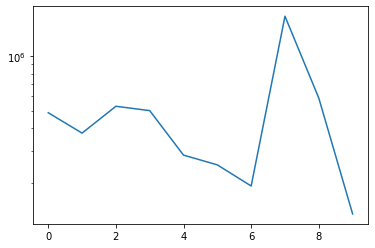

In [278]:
plt.plot(l)
plt.yscale('log')

## Plot Frames Loss

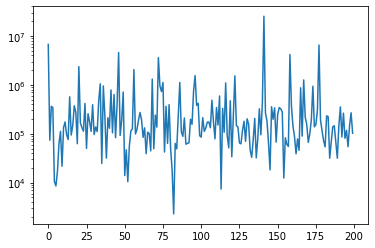

In [279]:
r = 1
plt.plot([sum(la[i:i+r])/r for i in range(0,len(la),r)])
plt.yscale('log')

## Prediction

In [280]:
Parameters = torch.load("NewModelParams.pth")
cap = open_vid("VDB/L.mp4")
Video = get_frames(cap)

In [288]:
N = 10
for _ in range(15):
    Video[N] = Frame2Numpy(AddOneInc1(Frame2Torch(Video[N],Normalize=True),random.randint(0,8),20,60,80,100),Denormalize=True)

In [282]:
def GenerateFrames(images, Params, frame_size=(320, 320)):

    PRED = []
    # Extract parameters from the dictionary
    C, P, F, B, K, KP, KPast, KFuture, WPP, WPF = Extract(Params)

    
    N = len(images)  # Total number of frames
    N_past = len(P)  # Number of past frames
    N_future = len(F)  # Number of future frames
    
    # Convert all frames to torch tensors
    torch_images = [Frame2Torch(img,frame_size,Normalize=True).float() for img in images]
    
    # Iterate through all the frames of the video
    for i in range(N - N_future):
        current = i + N_past
        first = i
        last = current + N_future
        # Select past, current, and future frames
        Past = torch_images[first:current]
        Current = torch_images[current]
        Future = torch_images[current+1:last]
        
        # Apply ObjFun to generate a new frame
        Pred = ObjFun(Current, Past, Future, C, P, F, B, K, KP, KPast, KFuture, WPP,WPF)
        
        # Convert the predicted frame back to numpy array and rescale to [0, 255]
        Pred_np = Frame2Numpy(Pred,(images[0].shape[1],images[0].shape[0]),Denormalize=True)
        
        PRED.append(Pred_np)
         
    return PRED

In [289]:
PRED = GenerateFrames(Video[:25],Parameters,(50,50))

In [290]:
[display_images([Video[b+5],PRED[b]]) for b in range(20)];